In [1]:
import torch as th
from torch.utils.data import Dataset
from torch import nn

from torchvision import transforms

import sys
import os

# Add the path to the folder containing ConvLSTM_model and utils
module_path = "../train"
sys.path.append(module_path)

from ConvLSTM_model import ConvLSTM_Model
from utils import SequenceDataset, SSIM_MSE_Loss

import pandas as pd

from IPython.display import Image

In [2]:
# define a dataset

id_data = pd.read_csv('../data/id_df_final.csv')

seq_len = id_data.groupby('sequence').size()
seq_len = seq_len.to_dict()
seq_rain = id_data.groupby('sequence')['rain_category'].mean()
seq_rain = seq_rain.to_dict()

seq_df = pd.DataFrame({'seq_len': seq_len, 'seq_rain': seq_rain})

# split the sequences in train and test set (80/20)
train_seq = seq_df.sample(frac=0.8, random_state=1)
test_seq = seq_df.drop(train_seq.index)

print(train_seq['seq_len'].mean(), test_seq['seq_len'].mean())
print(train_seq['seq_len'].std(), test_seq['seq_len'].std())
print(train_seq['seq_rain'].mean(), test_seq['seq_rain'].mean())
print(train_seq['seq_rain'].std(), test_seq['seq_rain'].std())

# get the sequences of the train and test set
train_seq_idx = train_seq.index
test_seq_idx = test_seq.index

train_data = id_data[id_data['sequence'].isin(train_seq_idx)]
train_data.shape

test_data = id_data[id_data['sequence'].isin(test_seq_idx)]
test_data.shape


115.44067796610169 118.83333333333333
110.87395957733693 86.95027644989202
2.150042010724777 2.116623367448169
0.8743386816727606 0.9540785561831368


(3565, 5)

In [3]:
id_data = None
seq_len = None
seq_rain = None
seq_df = None
train_seq = None
test_seq = None
train_seq_idx = None
test_seq_idx = None

In [ ]:
num_hidden = [16, 8, 8, 16]
num_layers = len(num_hidden)

custom_model_config = {
    'in_shape': [1, 128, 128], # T, C, H, W
    'patch_size': 1,
    'filter_size': 3,
    'stride': 2, # works only if transpose = True
    'layer_norm' : True,
    'reverse_scheduled_sampling': 0,
    'bias': False,
    'transpose': True, 
    'leaky_slope': None
}

if th.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

device = th.device("cuda" if th.cuda.is_available() else "cpu")
th.cuda.empty_cache()

# Instantiate the model
# Assuming x_train shape is (batch_size, sequence_length, channels, height, width)
model = ConvLSTM_Model(num_layers, num_hidden, custom_model_config, schedule_sampling=False)
model = nn.DataParallel(model)
model.to(device)

CUDA is not available.
64 64
32 32
64 64
128 128


DataParallel(
  (module): ConvLSTM_Model(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv_x): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
        )
        (conv_h): Sequential(
          (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
        )
      )
      (1): ConvLSTMCell(
        (conv_x): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
        )
        (conv_h): Sequential(
          (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
        )
      )
      (2): ConvLSTMCell(
        

In [13]:
images = ['tensor_2453267.pt',
 'tensor_2453247.pt',
 'tensor_2453227.pt',
 'tensor_2453209.pt',
 'tensor_2453187.pt',
 'tensor_2453147.pt',
 'tensor_2453127.pt',
 'tensor_2453107.pt',
 'tensor_2453087.pt',
 'tensor_2453067.pt']

In [14]:
# Loop over the dataset multiple times, with different sequence lengths to avoid the vanishing gradient problem
input_row = images[0:5]
output_row = images[5:]

inputs = [th.load(f"../data/images/{image}", weights_only=True) for image in input_row]
targets = [th.load(f"../data/images/{image}", weights_only=True) for image in output_row]
inputs = th.stack(inputs, dim=0)
targets = th.stack(targets, dim=0)
inputs = inputs.unsqueeze(0)  # Shape: [1, 5, 1, 128, 128]
targets = targets.unsqueeze(0)

In [15]:
# Define loss and optimizer
criterion = nn.MSELoss()
#criterion = SSIM_MSE_Loss(alpha=0.5)
criterion = nn.BCELoss()
alpha = 0.9
initial_lr = 0.1  # Start with a high learning rate
optimizer = th.optim.Adam(model.parameters(), lr=initial_lr)

for seq_len in range(2, 6):
    print(f"Training with sequence length {seq_len}")
    #alpha -= 0.1
    #criterion = SSIM_MSE_Loss(alpha=alpha)
    # Training loop
    num_epochs = 10  # Set the number of epochs
    # Lists to keep track of the losses for each epoch
    train_losses = []
    test_losses = []

    for epoch in range(seq_len*num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()
        outputs = model(inputs[:,0:seq_len], th.ones_like(inputs[:,0:seq_len]), schedule_sampling=False)
        loss = criterion(outputs, targets[:,0:seq_len])
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{seq_len*num_epochs}], Loss: {loss.item():.6f}")

print("Training complete!")

Training with sequence length 2
i_x: torch.Size([1, 16, 64, 64]), f_x: torch.Size([1, 16, 64, 64]), c_x: torch.Size([1, 16, 64, 64]), o_x: torch.Size([1, 16, 64, 64])
i_h: torch.Size([1, 16, 64, 64]), f_h: torch.Size([1, 16, 64, 64]), c_h: torch.Size([1, 16, 64, 64]), o_h: torch.Size([1, 16, 64, 64])
i_x: torch.Size([1, 8, 32, 32]), f_x: torch.Size([1, 8, 32, 32]), c_x: torch.Size([1, 8, 32, 32]), o_x: torch.Size([1, 8, 32, 32])
i_h: torch.Size([1, 8, 32, 32]), f_h: torch.Size([1, 8, 32, 32]), c_h: torch.Size([1, 8, 32, 32]), o_h: torch.Size([1, 8, 32, 32])
i_x: torch.Size([1, 8, 64, 64]), f_x: torch.Size([1, 8, 64, 64]), c_x: torch.Size([1, 8, 64, 64]), o_x: torch.Size([1, 8, 64, 64])
i_h: torch.Size([1, 8, 64, 64]), f_h: torch.Size([1, 8, 64, 64]), c_h: torch.Size([1, 8, 64, 64]), o_h: torch.Size([1, 8, 64, 64])
i_x: torch.Size([1, 16, 128, 128]), f_x: torch.Size([1, 16, 128, 128]), c_x: torch.Size([1, 16, 128, 128]), o_x: torch.Size([1, 16, 128, 128])
i_h: torch.Size([1, 16, 128, 12

KeyboardInterrupt: 

In [ ]:
input_pil_frames = [transforms.ToPILImage()(frame) for frame in inputs[0]]
true_pil_frames = [transforms.ToPILImage()(frame) for frame in targets[0]]

true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save('true.gif', save_all=True, append_images=true_gif_list[1:], duration=1000, loop=5)

predicted_frames = model(inputs, mask_true=th.ones_like(inputs))
predicted_frames = predicted_frames.squeeze(0)
predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]
pred_gif_list = input_pil_frames + predicted_pil_frames

# List of frames as PIL Image objects
# Duration sets the display time for each frame in milliseconds
# Loop sets the number of loops. Default is 0 and means infinite

pred_gif_list[0].save('pred.gif', save_all=True, append_images=pred_gif_list[1:], duration=1000, loop=5)

i_x: torch.Size([1, 16, 128, 128]), f_x: torch.Size([1, 16, 128, 128]), c_x: torch.Size([1, 16, 128, 128]), o_x: torch.Size([1, 16, 128, 128])
i_h: torch.Size([1, 16, 128, 128]), f_h: torch.Size([1, 16, 128, 128]), c_h: torch.Size([1, 16, 128, 128]), o_h: torch.Size([1, 16, 128, 128])
i_x: torch.Size([1, 8, 128, 128]), f_x: torch.Size([1, 8, 128, 128]), c_x: torch.Size([1, 8, 128, 128]), o_x: torch.Size([1, 8, 128, 128])
i_h: torch.Size([1, 8, 128, 128]), f_h: torch.Size([1, 8, 128, 128]), c_h: torch.Size([1, 8, 128, 128]), o_h: torch.Size([1, 8, 128, 128])
i_x: torch.Size([1, 8, 128, 128]), f_x: torch.Size([1, 8, 128, 128]), c_x: torch.Size([1, 8, 128, 128]), o_x: torch.Size([1, 8, 128, 128])
i_h: torch.Size([1, 8, 128, 128]), f_h: torch.Size([1, 8, 128, 128]), c_h: torch.Size([1, 8, 128, 128]), o_h: torch.Size([1, 8, 128, 128])
i_x: torch.Size([1, 16, 128, 128]), f_x: torch.Size([1, 16, 128, 128]), c_x: torch.Size([1, 16, 128, 128]), o_x: torch.Size([1, 16, 128, 128])
i_h: torch.Size

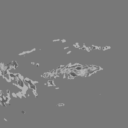

In [ ]:
Image(filename='pred.gif')

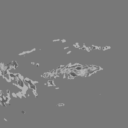

In [ ]:
Image(filename='true.gif')

In [ ]:
transposed_inputs = inputs[0].transpose(-2, -1)
transposed_targets = targets[0].transpose(-2, -1)

input_pil_frames = [transforms.ToPILImage()(frame) for frame in transposed_inputs]
true_pil_frames = [transforms.ToPILImage()(frame) for frame in transposed_targets]

true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save('true_trans.gif', save_all=True, append_images=true_gif_list[1:], duration=1000, loop=5)

predicted_frames = model(transposed_inputs.unsqueeze(0), mask_true=th.ones_like(inputs))
predicted_frames = predicted_frames.squeeze(0)
predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]
pred_gif_list = input_pil_frames + predicted_pil_frames

# List of frames as PIL Image objects
# Duration sets the display time for each frame in milliseconds
# Loop sets the number of loops. Default is 0 and means infinite

pred_gif_list[0].save('pred_trans.gif', save_all=True, append_images=pred_gif_list[1:], duration=1000, loop=5)

i_x: torch.Size([1, 16, 128, 128]), f_x: torch.Size([1, 16, 128, 128]), c_x: torch.Size([1, 16, 128, 128]), o_x: torch.Size([1, 16, 128, 128])
i_h: torch.Size([1, 16, 128, 128]), f_h: torch.Size([1, 16, 128, 128]), c_h: torch.Size([1, 16, 128, 128]), o_h: torch.Size([1, 16, 128, 128])
i_x: torch.Size([1, 8, 128, 128]), f_x: torch.Size([1, 8, 128, 128]), c_x: torch.Size([1, 8, 128, 128]), o_x: torch.Size([1, 8, 128, 128])
i_h: torch.Size([1, 8, 128, 128]), f_h: torch.Size([1, 8, 128, 128]), c_h: torch.Size([1, 8, 128, 128]), o_h: torch.Size([1, 8, 128, 128])
i_x: torch.Size([1, 8, 128, 128]), f_x: torch.Size([1, 8, 128, 128]), c_x: torch.Size([1, 8, 128, 128]), o_x: torch.Size([1, 8, 128, 128])
i_h: torch.Size([1, 8, 128, 128]), f_h: torch.Size([1, 8, 128, 128]), c_h: torch.Size([1, 8, 128, 128]), o_h: torch.Size([1, 8, 128, 128])
i_x: torch.Size([1, 16, 128, 128]), f_x: torch.Size([1, 16, 128, 128]), c_x: torch.Size([1, 16, 128, 128]), o_x: torch.Size([1, 16, 128, 128])
i_h: torch.Size

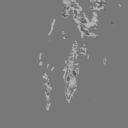

In [ ]:
Image(filename='pred_trans.gif')

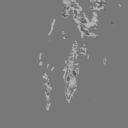

In [ ]:
Image(filename='true_trans.gif')